**Deep Learning | Assignment 1**

- Lívia Verly
- Luan Rodrigues

Setting up the environment

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, ColorJitter
#from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import time
import torchvision.transforms.functional as transf_F

Paths and directories

In [16]:
base_dir = 'camvid_data/'
train_dir = base_dir + 'train'
train_labels_dir = base_dir + 'train_labels'
val_dir = base_dir + 'val'
val_labels_dir = base_dir + 'val_labels'

class_dict_path = base_dir + 'class_dict.csv'



print('ok')

ok


Torch device

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Image tensor shape: torch.Size([4, 3, 360, 480]), <class 'torch.Tensor'>
Label tensor shape: torch.Size([4, 360, 480]), <class 'torch.Tensor'>


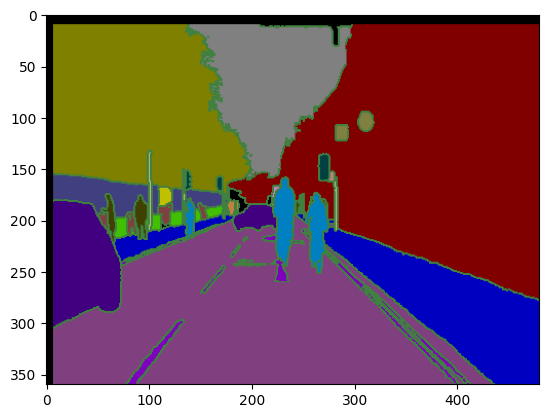

In [19]:
# Load class dictionary
class_dict: pd.DataFrame = pd.read_csv(class_dict_path)

# Create conversion dictionaries
rgb_to_label_dict: dict[tuple, int] = {
    (row['r'], row['g'], row['b']): idx
    for idx, row in class_dict.iterrows()
}

label_to_rgb_dict: dict[int, tuple] = {
    idx: (row['r'], row['g'], row['b'])
    for idx, row in class_dict.iterrows()
}

def rgb_to_label(image: torch.Tensor) -> torch.Tensor:
    width, height, _ = image.shape
    label_image = torch.zeros(width, height, device=device)

    # Transformar para inteiro, se necessário, para garantir comparação correta
    image = (image * 255).int()

    for rgb, label in rgb_to_label_dict.items():
        rgb_tensor = torch.tensor(rgb, device=device)
        mask = torch.all(image == rgb_tensor, dim=-1)
        label_image[mask] = label
        
    return label_image

def label_to_rgb_tensor(label_tensor: torch.Tensor) -> torch.Tensor:
    height, width = label_tensor.shape
    rgb_image = torch.zeros(3, height, width, dtype=torch.uint8)

    for label, rgb in label_to_rgb_dict.items():
        mask = (label_tensor == label)
        rgb_image[0][mask] = rgb[0]  # Red
        rgb_image[1][mask] = rgb[1]  # Green
        rgb_image[2][mask] = rgb[2]  # Blue

    return rgb_image

def read_image(image_path: str) -> torch.Tensor:
    image = Image.open(image_path)
    image = transforms.ToTensor()(image)
    return image

class CamVidDataset(Dataset):
    def __init__(self, img_dir: str, label_dir: str, augment: bool = False):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.augment = augment
        self.transform = transforms.Compose([
            transforms.Resize((360, 480)),
        ])
        self.img_files = os.listdir(img_dir)
        self.label_files = os.listdir(label_dir)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        label_file = img_file.replace(".png", "_L.png")  # Supondo que o sufixo das máscaras seja '_L'

        img_path = os.path.join(self.img_dir, img_file)
        label_path = os.path.join(self.label_dir, label_file)

        img = read_image(img_path).to(device)
        label = read_image(label_path).to(device)

        img = self.transform(img)
        label = self.transform(label)
        
        if self.augment:
            # Apply the same random transformations to both image and label
            if torch.rand(1) > 0.5:
                img = transf_F.hflip(img)
                label = transf_F.hflip(label)
            
            # Pad the image and label with the same padding value (using a tuple)
            img = transf_F.pad(img, (10, 10, 10, 10))  # padding on all sides
            label = transf_F.pad(label, (10, 10, 10, 10))  # padding on all sides
        

            # Apply the same cropping to both image and label
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(360, 480))
            img = transf_F.crop(img, i, j, h, w)
            label = transf_F.crop(label, i, j, h, w)
            
            # Color jitter only applies to the image
            img = transforms.ColorJitter(brightness=0.1, contrast=0, saturation=0, hue=0.2)(img)
        
        
        label = rgb_to_label(label.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)

        return img, label.long()

train_dataset = CamVidDataset(train_dir, train_labels_dir, augment=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

img, label = next(iter(train_loader))
print(f'Image tensor shape: {img.shape}, {type(img)}')
print(f'Label tensor shape: {label.shape}, {type(label)}')


rgb_tens = label_to_rgb_tensor(label[0])
rgb_image = Image.fromarray(rgb_tens.permute(1, 2, 0).numpy())
plt.imshow(rgb_image)
plt.show()

del(train_dataset, train_loader, img, label)          


In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=32, depth=5):
        super(UNet, self).__init__()
        self.depth = depth  # Variable depth
        self.down_convs = nn.ModuleList()  # Encoder layers
        self.up_convs = nn.ModuleList()  # Decoder layers
        self.trans_convs = nn.ModuleList()  # Transposed convolutions (upsampling)
        i = 3 # Initial exponent of channel size

        # Encoder (Contracting Path)
        for d in range(depth):
            input_channels = in_channels if d == 0 else 2**(i + d - 1)
            output_channels = 2**(i + d)
            self.down_convs.append(self.conv_block(input_channels, output_channels))

        # Bottleneck
        self.bottleneck = self.conv_block(2**(i + depth - 1), 2**(i + depth))

        # Decoder (Expanding Path)
        for d in range(depth, 0, -1):
            input_channels = 2**(i + d)
            output_channels = 2**(i + d - 1)
            self.trans_convs.append(nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2))
            self.up_convs.append(self.conv_block(input_channels, output_channels))

        # Output layer
        self.out_conv = nn.Conv2d(2**i, num_classes, kernel_size=1)

    def forward(self, x):
        enc_outputs = []  # To store outputs from each encoder layer

        # Encoder
        for enc in self.down_convs:
            x = enc(x)
            enc_outputs.append(x)
            x = F.max_pool2d(x, 2)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        for idx in range(self.depth):
            x = self.trans_convs[idx](x)
            x = self.crop_and_concat(x, enc_outputs[-(idx+1)])
            x = self.up_convs[idx](x)

        # Ensure the final output has the same size as input
        if x.size(2) != enc_outputs[0].size(2):
            x = F.interpolate(x, size=(enc_outputs[0].size(2), enc_outputs[0].size(3)), mode='bilinear', align_corners=False)


        return self.out_conv(x)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def crop_and_concat(self, upsampled, bypass):
        crop_h = (bypass.size(2) - upsampled.size(2)) // 2
        crop_w = (bypass.size(3) - upsampled.size(3)) // 2
        bypass = bypass[:, :, crop_h:crop_h + upsampled.size(2), crop_w:crop_w + upsampled.size(3)]
        return torch.cat((upsampled, bypass), dim=1)

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model = model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        for images, labels in train_loader:
            images = images.to(device) # Send data to device
            labels = labels.to(device) # Send data to device

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate pixel-wise accuracy
            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == labels).sum().item()
            total_pixels += labels.numel()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_pixels / total_pixels

        # Validation phase
        model.eval()
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        end_time = time.time()
        epoch_time = end_time - start_time

        print("="*100)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.4f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if (epoch + 1) % 10 == 0:  # For example, visualize every 5 epochs
            visualize_segmentation(model, val_loader, device)

    return model, history


def validate_model(model, val_loader, criterion, device='cuda'):
    model.eval()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == labels).sum().item()
            total_pixels += labels.numel()
            
    val_loss = running_loss / len(val_loader)
    val_acc = correct_pixels / total_pixels

    return val_loss, val_acc

def visualize_segmentation(model, val_loader, device):
    model.eval()
    batch_idx = random.randint(0, len(val_loader) - 1)
    images, labels = list(val_loader)[batch_idx]
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        print(outputs.shape)
        preds = torch.argmax(outputs, dim=1)
        print(preds.shape)

    img_idx = random.randint(0, len(images) - 1)
    img = images[img_idx].cpu().numpy().transpose(1, 2, 0)
    label = labels[img_idx].cpu().numpy()
    pred = preds[img_idx].cpu().numpy()
    pred_rgb = label_to_rgb_tensor(pred).cpu().numpy().transpose(1, 2, 0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    
    axes[1].imshow(label_to_rgb_tensor(label).permute(1, 2, 0).cpu().numpy())
    axes[1].set_title('Ground Truth')

    axes[2].imshow(pred_rgb)
    axes[2].set_title('Predicted Mask')

    plt.show()

In [22]:
# Dataset and DataLoader
train_dataset = CamVidDataset(img_dir=train_dir, label_dir=train_labels_dir)
val_dataset = CamVidDataset(img_dir=val_dir, label_dir=val_labels_dir)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)

In [23]:
# Model, criterion, optimizer
model = UNet(in_channels=3, num_classes=32, depth=5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

torch.Size([4, 32, 360, 480])
torch.Size([4, 360, 480])


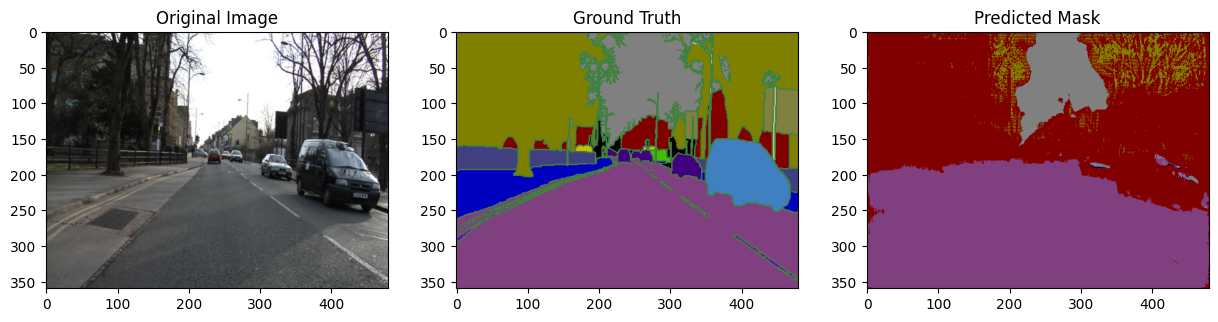

In [30]:
visualize_segmentation(model, val_loader, 'cpu')

In [24]:
checkpoint = torch.load('checkpoints/models50.pth')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
history = checkpoint['history']

C:\Users\Jesus\AppData\Local\Temp\ipykernel_22732\748933905.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/models50.pth')


In [ ]:
# Train and validate the model
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cuda')

In [37]:
checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'history': history,
        }
torch.save(checkpoint, f'checkpoints/models50.pth')

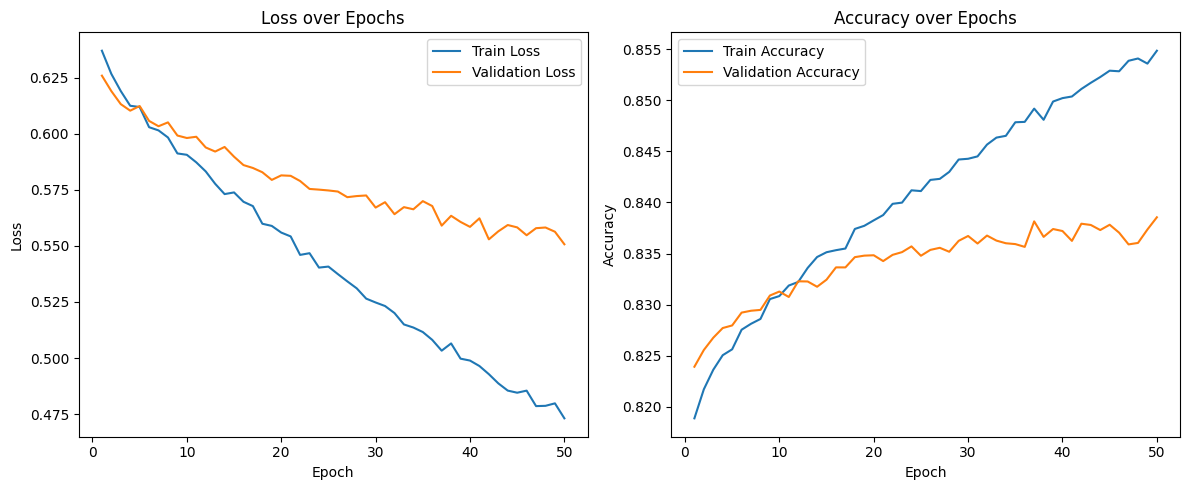

In [6]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(history)


In [18]:
# Create datasets with augmentation applied only to the training set
train_dataset_aug = CamVidDataset(img_dir=train_dir, label_dir=train_labels_dir, augment=True)
val_dataset_aug = CamVidDataset(img_dir=val_dir, label_dir=val_labels_dir, augment=True)

train_loader_aug = torch.utils.data.DataLoader(train_dataset_aug, batch_size=4, shuffle=True)
val_loader_aug = torch.utils.data.DataLoader(val_dataset_aug, batch_size=4, shuffle=True)

# Model, criterion, optimizer (no augmentation)
model_aug = UNet(in_channels=3, num_classes=32, depth=5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#summary(model, (3, 360, 480))


In [ ]:
model_aug, history_aug = train_model(
    model_aug,
    train_loader_aug,
    val_loader_aug,
    criterion,
    optimizer,
    num_epochs = 3,
    device = 'cuda',
)

## Testing the model

In [21]:
def evaluate_model(model, test_loader, device='cuda'):
    model = model.to(device)  # Move the model to the correct device (GPU or CPU)
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device)  # Move the image to the correct device (GPU or CPU)
            label = label.to(device)  # Move the label to the correct device (GPU or CPU)
            
            # Forward pass
            outputs = model(img)
            _, preds = torch.max(outputs, 1)
            
            all_preds.append(preds.cpu())  # Move predictions to CPU to store them
            all_labels.append(label.cpu())  # Move labels to CPU to store them
    
    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_preds, all_labels


In [22]:
# # Define the test dataset and DataLoader
# test_dataset = CamVidDataset(img_dir=test_dir, label_dir=test_labels_dir, augment=False)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# # Evaluate the model
# test_preds, test_labels = evaluate_model(model, test_loader, device='cuda')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
 
def compute_accuracy(preds, labels):
    correct = (preds == labels).sum().item()
    total = labels.numel()
    accuracy = correct / total
    return accuracy

def compute_iou(preds, labels, num_classes):
    iou_list = []
    for i in range(num_classes):
        pred_i = (preds == i)
        label_i = (labels == i)
        intersection = (pred_i & label_i).sum().item()
        union = (pred_i | label_i).sum().item()
        iou = intersection / union if union != 0 else 0
        iou_list.append(iou)
    return np.mean(iou_list)

def compute_precision_recall_f1(preds, labels, num_classes):
    preds = preds.numpy()
    labels = labels.numpy()
    
    precision = precision_score(labels.flatten(), preds.flatten(), average='weighted', zero_division=0)
    recall = recall_score(labels.flatten(), preds.flatten(), average='weighted', zero_division=0)
    f1 = f1_score(labels.flatten(), preds.flatten(), average='weighted', zero_division=0)
    print(precision)
    print(recall)
    return precision, recall, f1
    